In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#method : scaling, log transformation, cube Root normalization, Box-Cox transformation
from scipy.stats import skew 
from scipy.stats import boxcox

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/heart_2020_cleaned.csv')
df.shape

(319795, 18)

In [ ]:
df = df.drop_duplicates()
df.shape

(301717, 18)

In [ ]:
df = df[(df['BMI'] < 80) & (df['SleepTime'] != 24)]
df.shape

(301653, 18)

In [ ]:
def yesno_tolabel(x):
    if (x == 'Yes') | (x == 'Yes (during pregnancy)') :
        return 1
    else:
        return 0

In [ ]:
sex_map = {'Female' : 0, 'Male' : 1}
health_map = {'Excellent' : 4, 'Very good' : 3, 'Good' : 2, 'Fair' : 1, 'Poor' : 0}
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
age_map = {'18-24' : 20, '25-29' : 25, '30-34' : 30, '35-39' : 35, '40-44' : 40, '45-49' : 45, '50-54' : 50, '55-59' : 55, '60-64' : 60, '65-69' : 65, '70-74' : 70, '75-79' : 75, '80 or older' : 80}
columns = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
diabetic_map = {'Yes' : 2, 'Yes (during pregnancy)' : 2, 'No, borderline diabetes' : 1, 'No' : 0}
for column in columns:
    df[column] = df[column].apply(lambda x : yesno_tolabel(x))

df['Sex'] = df['Sex'].map(sex_map)
df['GenHealth'] = df['GenHealth'].map(health_map)
df['Diabetic'] = df['Diabetic'].map(diabetic_map)
df['AgeCategory'] = df['AgeCategory'].map(age_map)


In [ ]:
def quantile_operation(outlier_df, column):
    quantile_1 = outlier_df[column].quantile(0.25)
    quantile_3 = outlier_df[column].quantile(0.75)
    iqr = quantile_3 - quantile_1
    Lower_tail = quantile_1 - 1.5 * iqr
    Upper_tail = quantile_3 + 1.5 * iqr

    return Lower_tail, Upper_tail

In [ ]:
df['PhysicalHealth'] = df['PhysicalHealth'] + 1
df['MentalHealth'] = df['MentalHealth'] + 1
outlier_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
for column in outlier_columns:
    Lower_tail, Upper_tail = quantile_operation(df, column)
    df[column] = boxcox(df[column])[0]

In [ ]:
#Race 인코딩 - Binary
import category_encoders as ce
import pandas as pd

ce_binary = ce.BinaryEncoder(cols = ['Race'], return_df = True)
ce_binary_encoded = ce_binary.fit_transform(df['Race'])

df = pd.concat([df, ce_binary_encoded], axis = 1).drop(['Race'], axis = 1)

In [ ]:
#Race 인코딩 - target encoding
categories = df['Race'].unique()
targets = df['HeartDisease'].unique()
cat_list = []

for cat in categories:
    aux_dict = {}
    aux_dict['category'] = cat
    aux_df = df[df['Race'] == cat]
    counts = aux_df['HeartDisease'].value_counts()
    aux_dict['count'] = sum(counts)
    for t in targets:
        aux_dict['Race_' + str(t)] = counts[t]
    cat_list.append(aux_dict)

cat_list = pd.DataFrame(cat_list)
cat_list['genre_encoded_dumb'] = cat_list['Race_1'] / cat_list['count']

target_dict = {'White' : cat_list['genre_encoded_dumb'][0], 'Black' : cat_list['genre_encoded_dumb'][1], 'Asian' : cat_list['genre_encoded_dumb'][2], 'American Indian/Alaskan Native' : cat_list['genre_encoded_dumb'][3],
               'Other' : cat_list['genre_encoded_dumb'][4], 'Hispanic' : cat_list['genre_encoded_dumb'][5]}
df['Race_encoder'] = df['Race'].map(target_dict)

df.drop(['Race'], axis = 1, inplace = True)


In [ ]:
#Race 인코딩 - 원핫인코딩
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(sparse = False)
train_race = ohe.fit_transform(df[['Race']])

ohe_hot_df = pd.DataFrame(train_race, columns = ohe.categories_)

df = df.reset_index().drop('index', axis = 1)

df = pd.concat([df, ohe_hot_df], axis = 1).drop('Race', axis = 1)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,...,SleepTime,Asthma,KidneyDisease,SkinCancer,"(American Indian/Alaskan Native,)","(Asian,)","(Black,)","(Hispanic,)","(Other,)","(White,)"
0,0,1.403407,1,0,0,0.669364,1.089487,0,0,55,...,3.488639,1,0,1,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1.442302,0,0,1,0.000000,0.000000,0,0,80,...,5.054525,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1.487128,1,0,0,0.801003,1.089487,0,1,65,...,5.813435,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1.472250,0,0,0,0.000000,0.000000,0,0,75,...,4.280563,0,0,1,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1.468816,0,0,0,0.807551,0.000000,1,0,40,...,5.813435,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301648,1,1.491857,1,0,0,0.755892,0.000000,1,1,60,...,4.280563,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0
301649,0,1.504497,1,0,0,0.000000,0.000000,0,1,35,...,3.488639,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0
301650,0,1.472452,0,0,0,0.000000,0.000000,0,0,45,...,4.280563,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
301651,0,1.517915,0,0,0,0.000000,0.000000,0,0,25,...,8.734516,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
x = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state =42)
print('origin target data : \n', df['HeartDisease'].value_counts())

origin target data : 
 0    274401
1     27252
Name: HeartDisease, dtype: int64


In [ ]:
y_test.value_counts()

0    54845
1     5486
Name: HeartDisease, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1 socre:', f1_score(y_test, y_pred))
print('roc auc score : ', roc_auc_score(y_test, y_pred))

accuracy: 0.8998524804826706
precision: 0.3497297297297297
recall: 0.11793656580386438
f1 socre: 0.17639040348964016
roc auc score :  0.5480010115007107


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
max_depth = [4, 8, 10]
bootstrap = [True, False]
min_samples_split = [2, 4, 6]
min_samples_leaf = [2, 4, 6]
n_estimators = [100, 200, 300, 500]

random_grid = {'n_estimators' : n_estimators, 'max_features' : max_features, 'max_depth' : max_depth,
               'bootstrap' : bootstrap, 'min_samples_leaf' : min_samples_leaf, 'min_samples_split' : min_samples_split}
model = RandomForestClassifier()
rnd_search = RandomizedSearchCV(model, param_distributions = random_grid, n_iter = 10,
                                n_jobs = -1, random_state = 42, verbose = 1, cv = 3, scoring = 'accuracy')
rnd_search.fit(x_train, y_train)

cvres = rnd_search.cv_results_
print('최적 하이퍼파라미터 : ', rnd_search.best_params_)
y_test_pred = rnd_search.predict(x_test)
print('검증 정확도: ', rnd_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적 하이퍼파라미터 :  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
검증 정확도:  0.9112679331729506


In [ ]:
#binary hyper parameter
model = RandomForestClassifier(n_estimators = 300, min_samples_split = 4, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 10, bootstrap = False)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1 socre:', f1_score(y_test, y_pred))
print('roc auc score : ', roc_auc_score(y_test, y_pred))

accuracy: 0.9104440503223882
precision: 0.610079575596817
recall: 0.041924899744804955
f1 socre: 0.07845812723861503
roc auc score :  0.5196223094767419


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight = "balanced")
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1 socre:', f1_score(y_test, y_pred))
print('roc auc score : ', roc_auc_score(y_test, y_pred))

accuracy: 0.8987087898427011
precision: 0.3209169054441261
recall: 0.1020780167699599
f1 socre: 0.15488867376573087
roc auc score :  0.5402358358077167


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
max_depth = [4, 8, 10]
bootstrap = [True, False]
min_samples_split = [2, 4, 6]
min_samples_leaf = [2, 4, 6]
n_estimators = [100, 200, 300, 500]

random_grid = {'n_estimators' : n_estimators, 'max_features' : max_features, 'max_depth' : max_depth,
               'bootstrap' : bootstrap, 'min_samples_leaf' : min_samples_leaf, 'min_samples_split' : min_samples_split}
model = RandomForestClassifier(class_weight = 'balanced')
rnd_search = RandomizedSearchCV(model, param_distributions = random_grid, n_iter = 10,
                                n_jobs = -1, random_state = 42, verbose = 1, cv = 3, scoring = 'accuracy')
rnd_search.fit(x_train, y_train)

cvres = rnd_search.cv_results_
print('최적 하이퍼파라미터 : ', rnd_search.best_params_)
y_test_pred = rnd_search.predict(x_test)
print('검증 정확도: ', rnd_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적 하이퍼파라미터 :  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
검증 정확도:  0.7356560872288971


In [ ]:
from imblearn.over_sampling import *

x_train_SMOTE, y_train_SMOTE =SMOTE(random_state=42).fit_resample(x_train, y_train) # 거의 10초

#BorderlineSMOTE
x_train_BorderlineSM, y_train_BorderlineSM =BorderlineSMOTE(random_state=42).fit_resample(x_train, y_train) #거의 1분30초

#SVMSMOTE
x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) #14분 11초

#ADASYN
x_train_ADASYN, y_train_ADASYN =ADASYN(random_state=42).fit_resample(x_train, y_train) #거의 2분걸림'''

In [ ]:
from imblearn.over_sampling import *

x_train_SVMSMOTE, y_train_SVMSMOTE =SVMSMOTE(random_state=42).fit_resample(x_train, y_train) #14분 11초


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
max_depth = [8, 10, 12]
bootstrap = [True, False]
min_samples_split = [2, 4, 6]
min_samples_leaf = [2, 4, 6]
n_estimators = [100, 200, 300, 500]

random_grid = {'n_estimators' : n_estimators, 'max_features' : max_features, 'max_depth' : max_depth,
               'bootstrap' : bootstrap, 'min_samples_leaf' : min_samples_leaf, 'min_samples_split' : min_samples_split}
model = RandomForestClassifier()
rnd_search = RandomizedSearchCV(model, param_distributions = random_grid, n_iter = 10,
                                n_jobs = -1, random_state = 42, verbose = 1, cv = 3, scoring = 'accuracy')
rnd_search.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)

cvres = rnd_search.cv_results_
print('최적 하이퍼파라미터 : ', rnd_search.best_params_)
y_test_pred = rnd_search.predict(x_test)
print('검증 정확도: ', rnd_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적 하이퍼파라미터 :  {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
검증 정확도:  0.8242431512906


In [ ]:
#binary svmsmote hyper parameter
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(n_estimators = 300, min_samples_split = 4, min_samples_leaf = 4, max_features = 'sqrt', max_depth = 10, bootstrap = False)
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)

y_pred = model.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1 socre:', f1_score(y_test, y_pred))
print('roc auc score : ', roc_auc_score(y_test, y_pred))

accuracy: 0.8094677694717475
precision: 0.27017517019811826
recall: 0.6438206343419614
f1 socre: 0.38062395603211385
roc auc score :  0.7349288238716827


In [ ]:
!pip install pdpbox
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pdpbox import pdp
import shap

print(x_test.columns)
#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime', 'Race_encoder']
features = x_test.columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_encoder'],
      dtype='object')


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


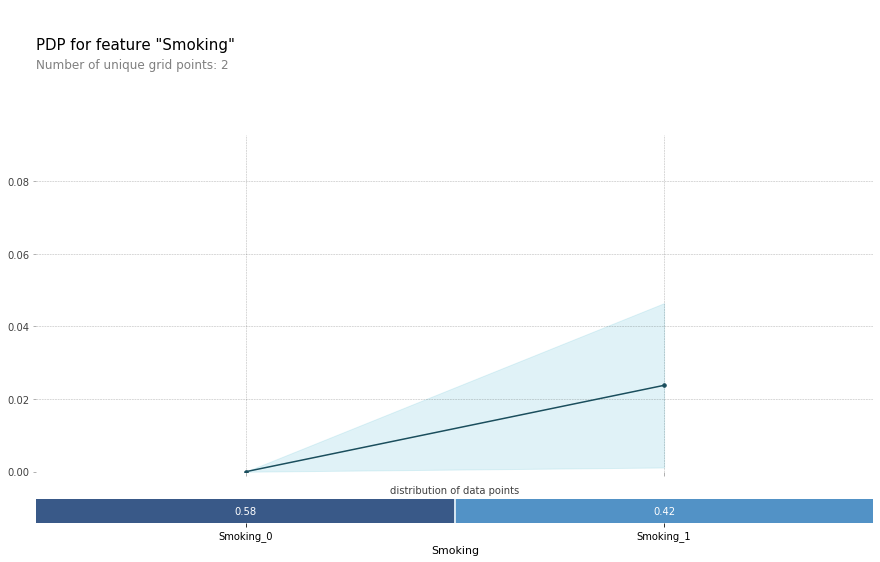

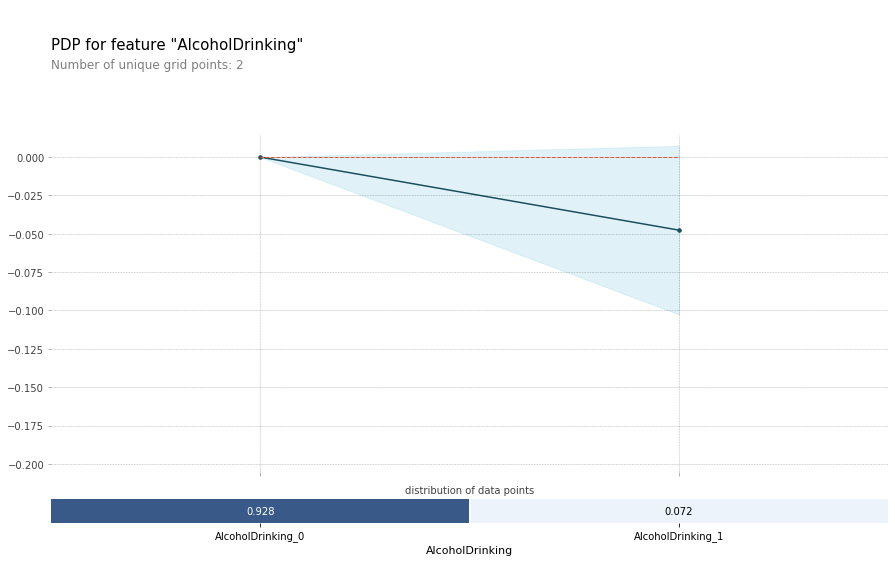

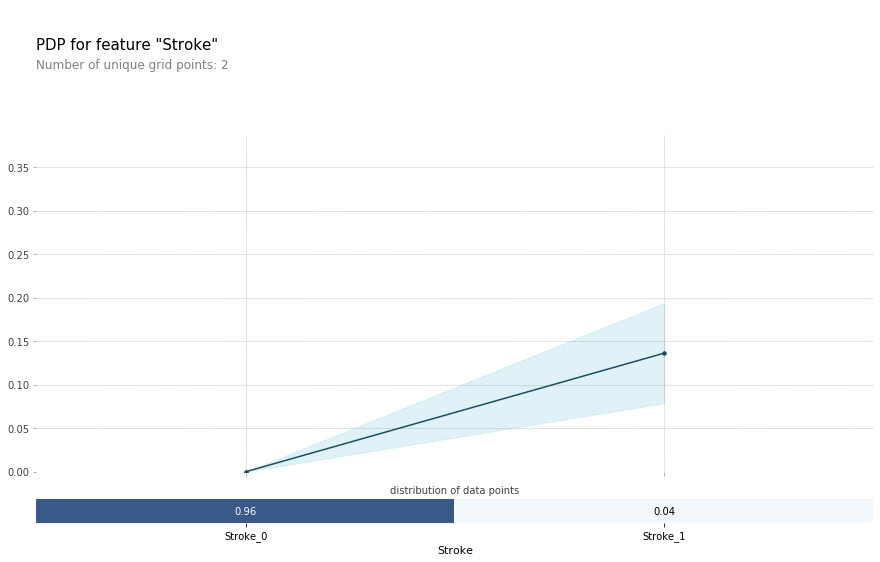

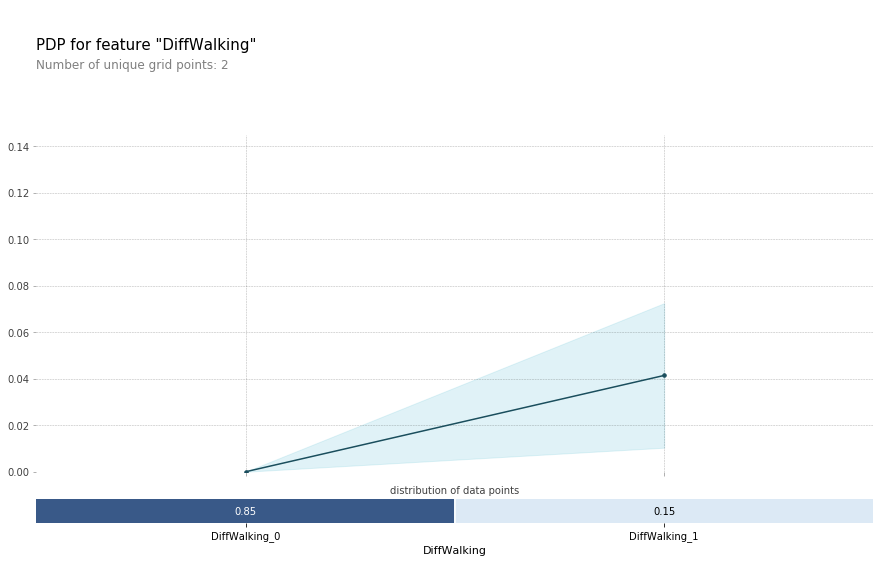

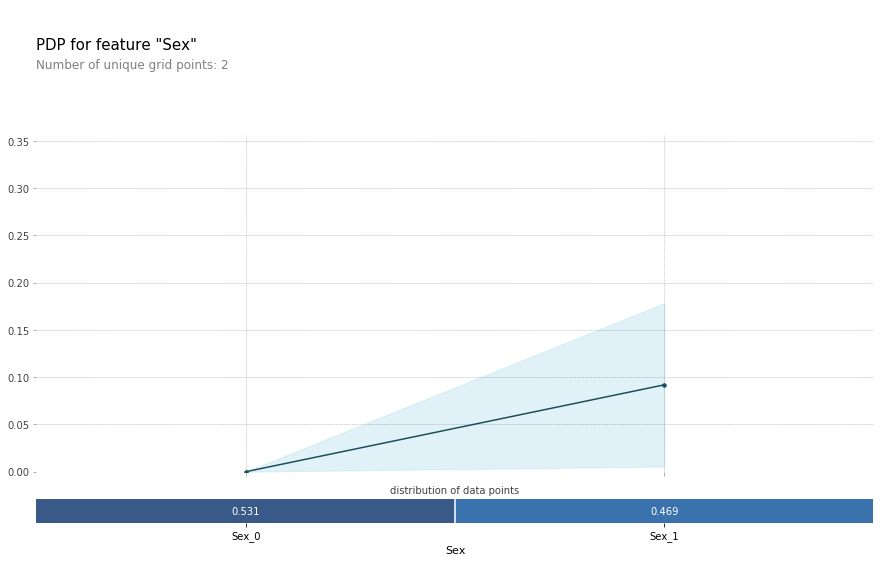

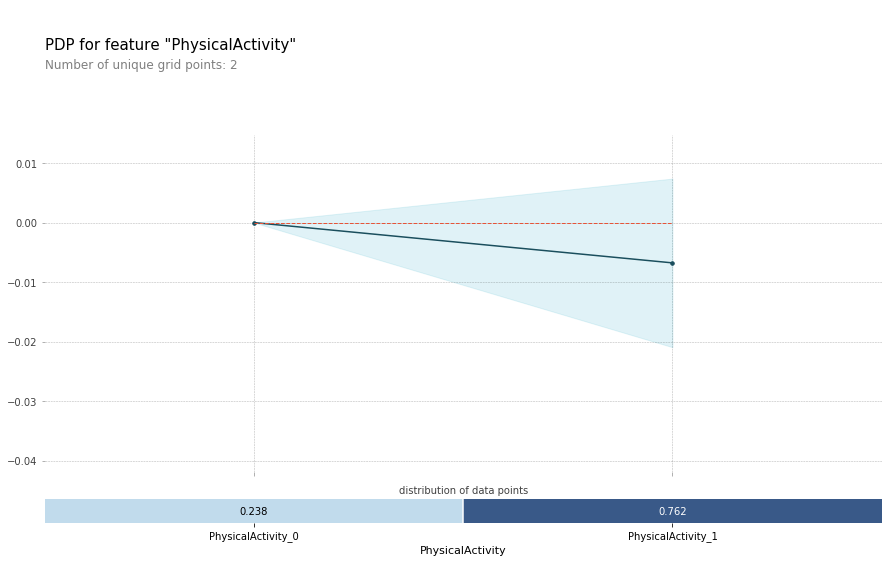

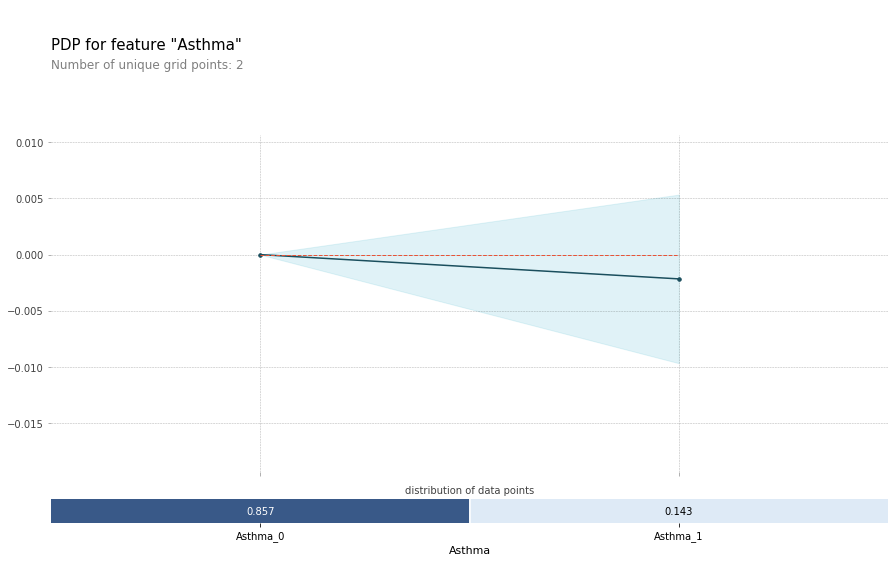

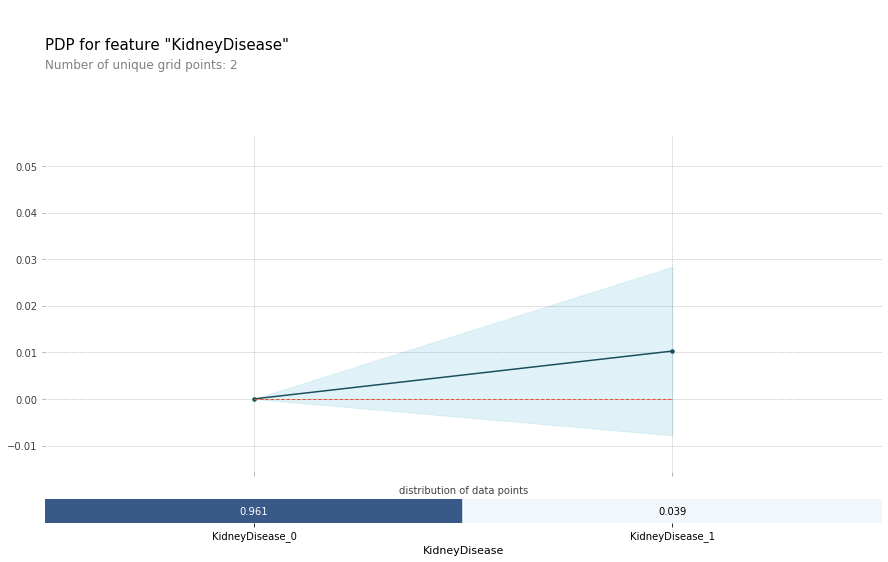

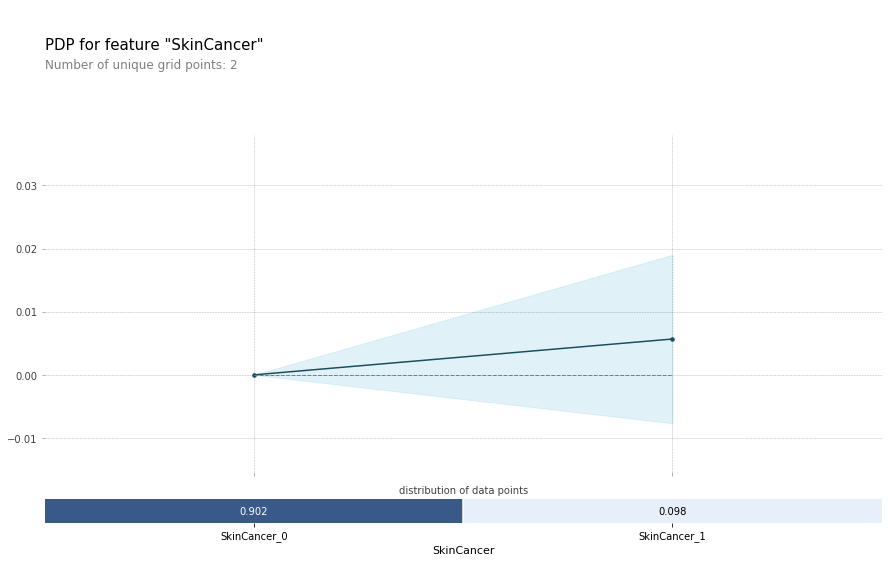

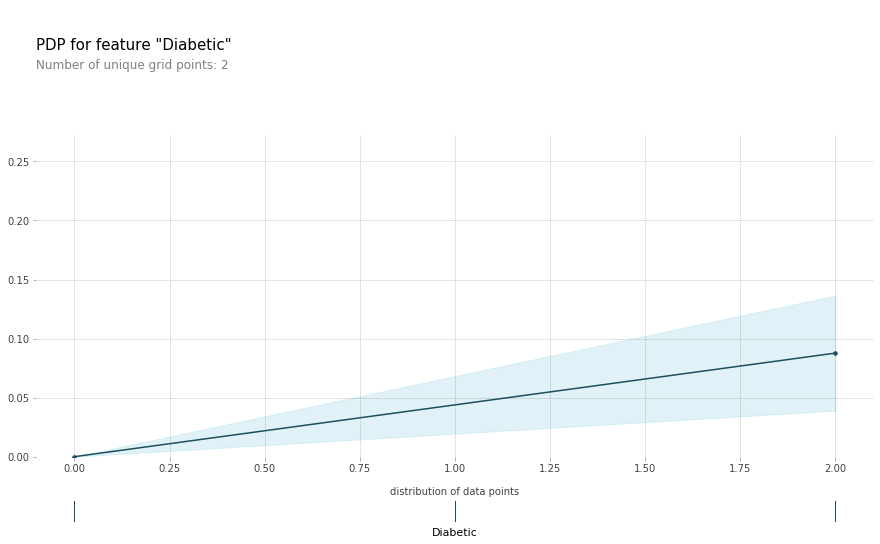

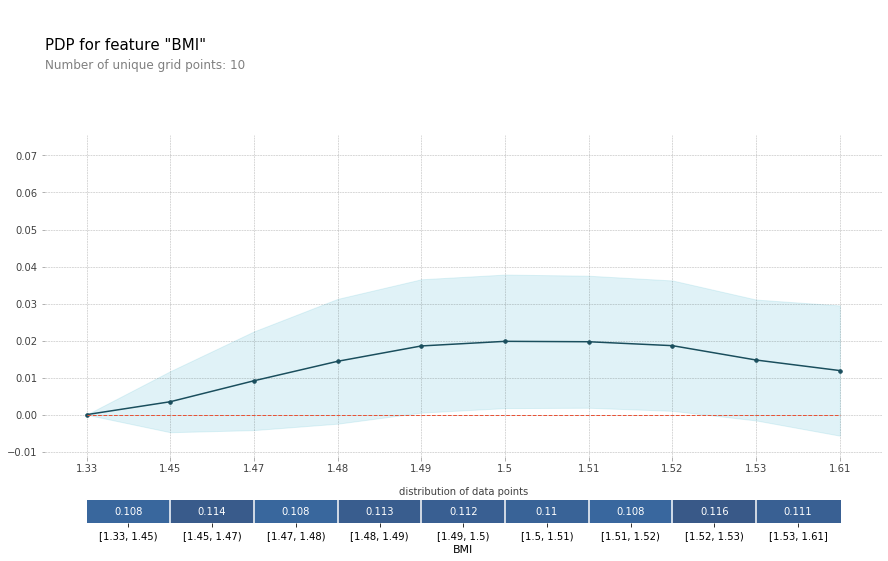

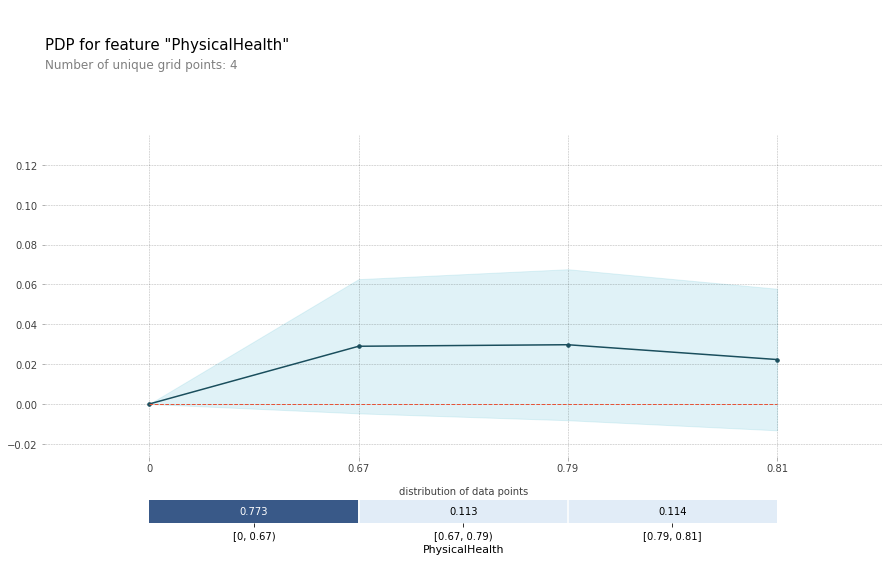

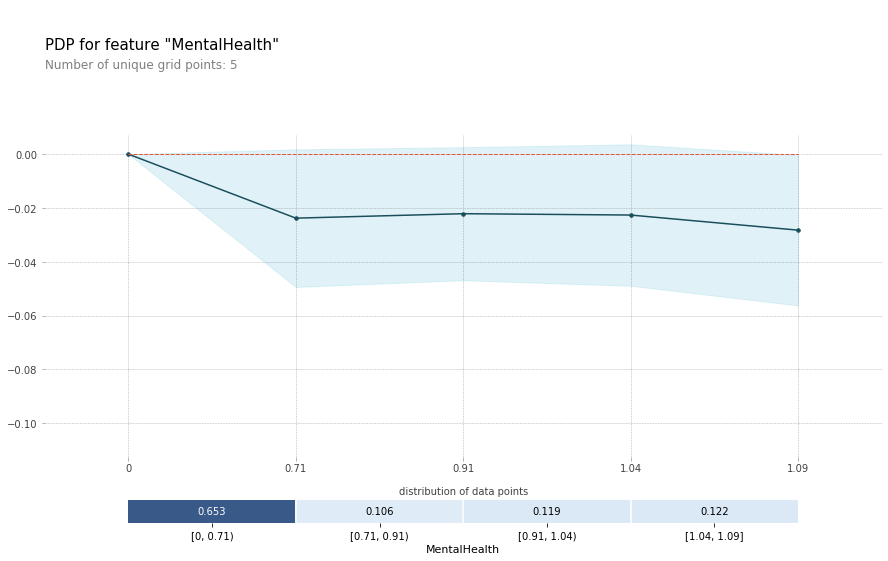

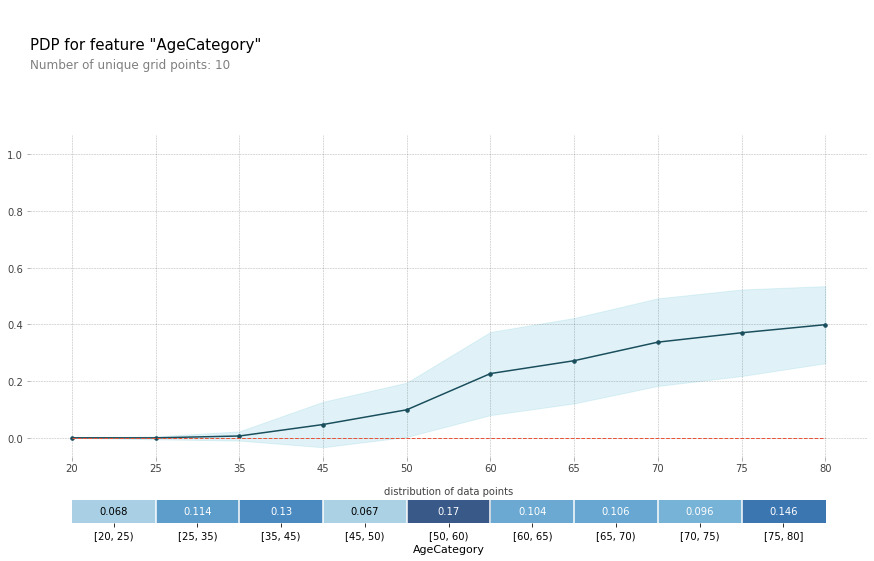

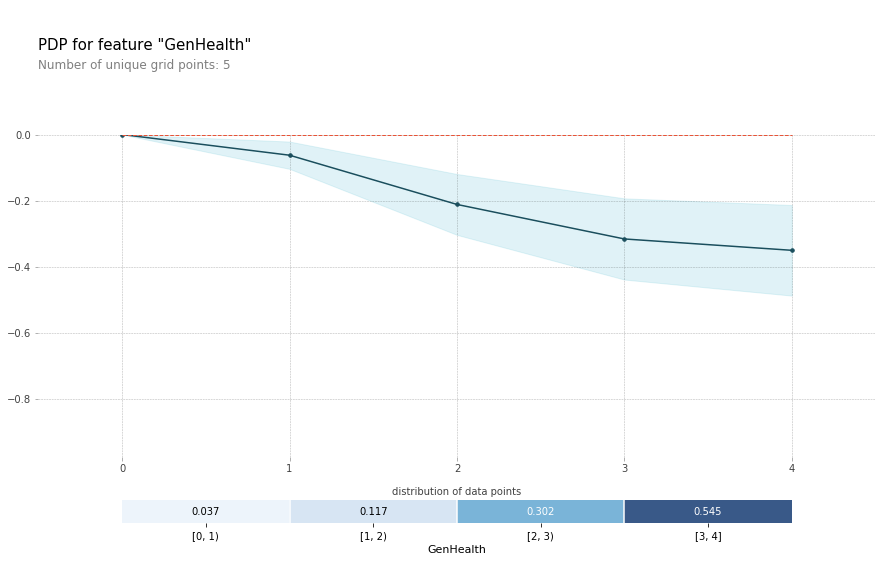

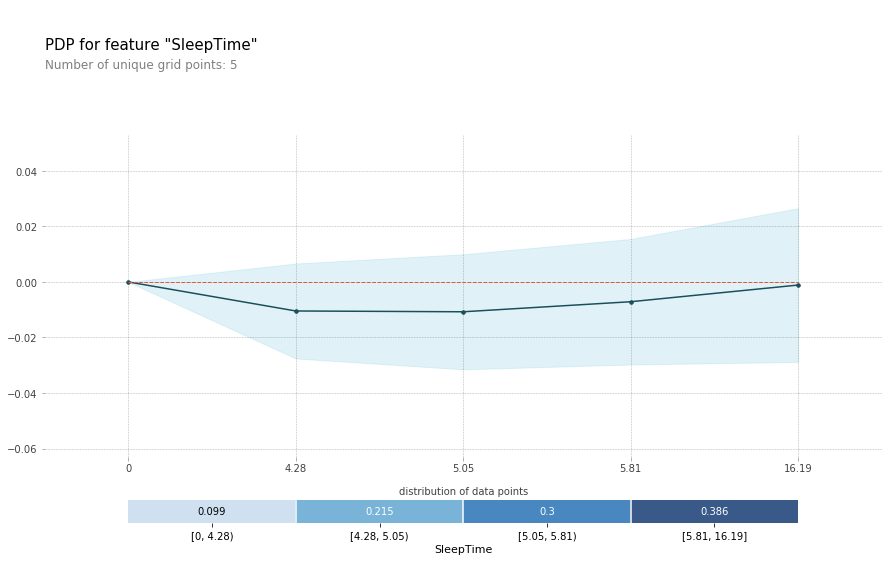

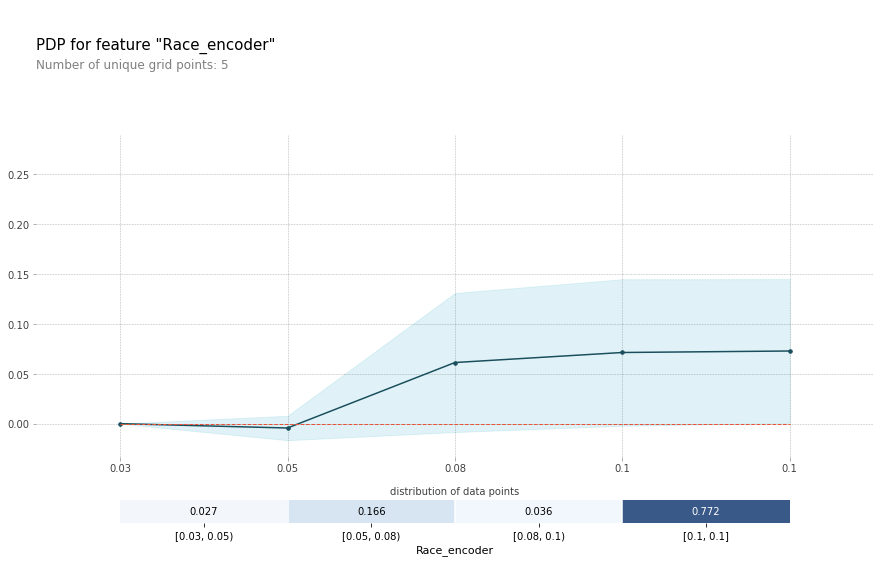

In [ ]:
# 샘플링 없는 pdp
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# 샘플링 적용안한 경우의 center ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=800, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=800, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

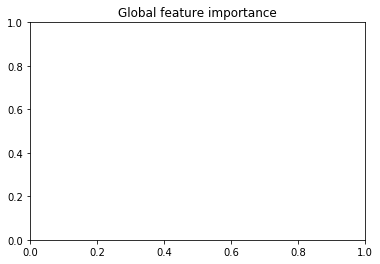

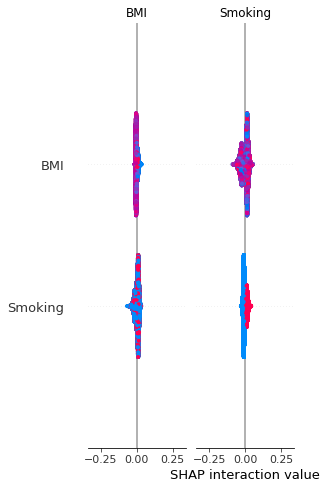

In [ ]:
plt.title('Global feature importance')
shap.summary_plot(shap_values,feature_names=features)

In [ ]:
# 복합 샘플링 진행 
from imblearn.combine import *

## SMOTETomek <- 얘는 사용 안하기로 해서 주석처리 하겠습니다.
#x_train_SMOTETomek, y_train_SMOTETomek =SMOTETomek(random_state=42).fit_resample(x_train, y_train)  #33분 16초

#SMOTETENN
x_train_SMOTEENN, y_train_SMOTEENN =SMOTEENN(random_state=42).fit_resample(x_train, y_train) #56분 19초

KeyboardInterrupt: ignored

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

max_features = ['auto', 'sqrt']
max_depth = [4, 8, 10]
bootstrap = [True, False]
min_samples_split = [4, 6]
min_samples_leaf = [4, 6]
n_estimators = [100, 200]

random_grid = {'n_estimators' : n_estimators, 'max_features' : max_features, 'max_depth' : max_depth,
               'bootstrap' : bootstrap, 'min_samples_leaf' : min_samples_leaf, 'min_samples_split' : min_samples_split}
model = RandomForestClassifier()
rnd_search = RandomizedSearchCV(model, param_distributions = random_grid, n_iter = 10,
                                n_jobs = -1, random_state = 42, verbose = 1, cv = 3, scoring = 'accuracy')
rnd_search.fit(x_train_SMOTEENN, y_train_SMOTEENN)

cvres = rnd_search.cv_results_
print('최적 하이퍼파라미터 : ', rnd_search.best_params_)
y_test_pred = rnd_search.predict(x_test)
print('검증 정확도: ', rnd_search.best_score_)

In [ ]:
#로지스틱 이용 샘플링 안한경우
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 4, min_samples_leaf = 6, max_features = 'sqrt', max_depth = 10, bootstrap = False)
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

print('OverSampling SVMSMOTE')

print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

OverSampling SVMSMOTE
Accuracy 0.7390230561402927
Precision 0.22635369431848493
Recall 0.7734232592052497
F1 0.35021253765837146
AUC 0.8300215232222238
[[40343 14502]
 [ 1243  4243]]


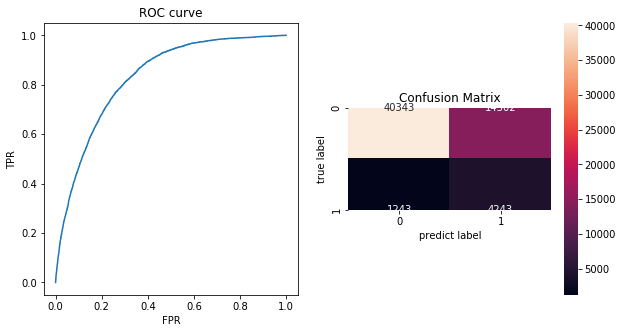

In [ ]:
#로지스틱 이용 샘플링 안한경우
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 4, min_samples_leaf = 6, max_features = 'sqrt', max_depth = 10, bootstrap = False)
model.fit(x_train_SMOTEENN, y_train_SMOTEENN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

print('OverSampling SVMSMOTE')

print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False', figsize = (12, 12))
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

In [ ]:
from pdpbox import pdp
import shap

print(x_test.columns)
#분포를 보기위해 yes no와 그 외로 피쳐 분리
feature = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',  'PhysicalActivity',   'Asthma', 'KidneyDisease',
       'SkinCancer', 'Diabetic']
feature2=['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory',  'GenHealth', 'SleepTime', 'Race_encoder']
features = x_test.columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic',
       'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Race_encoder'],
      dtype='object')


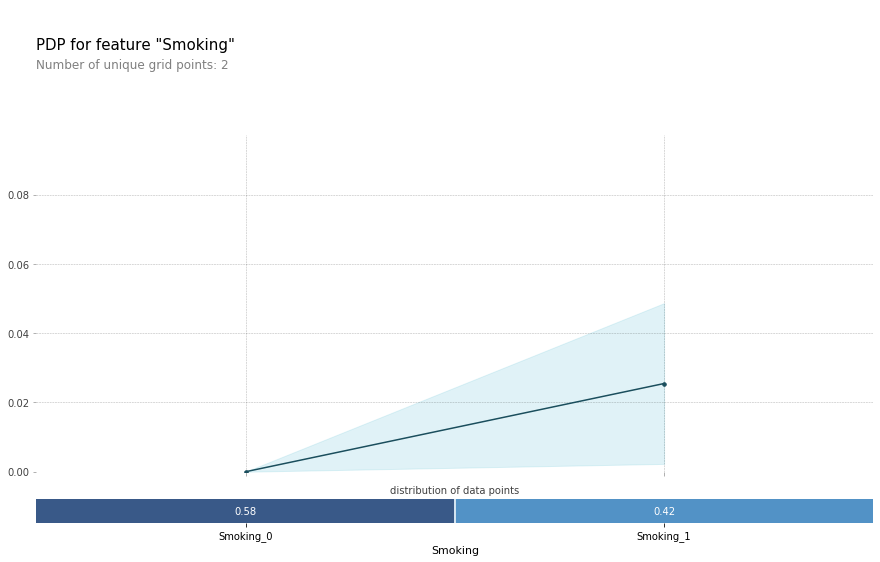

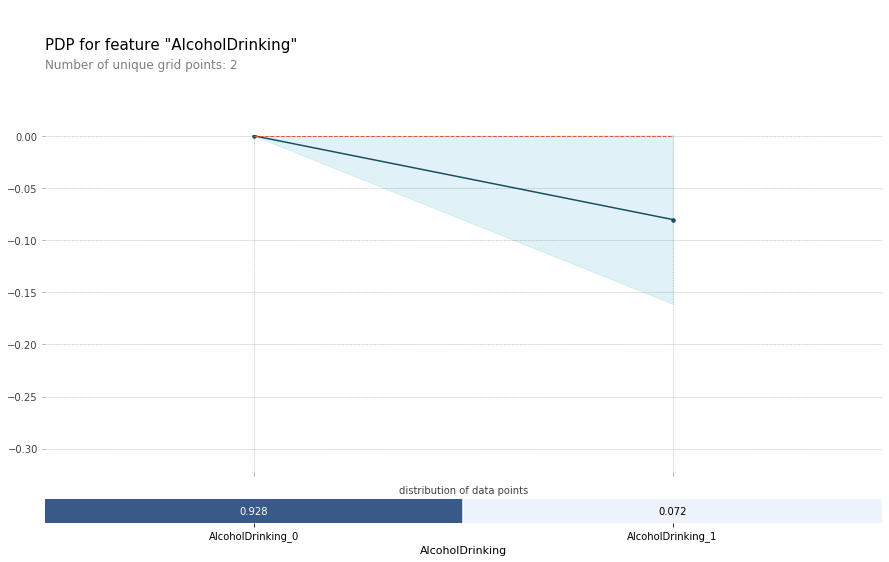

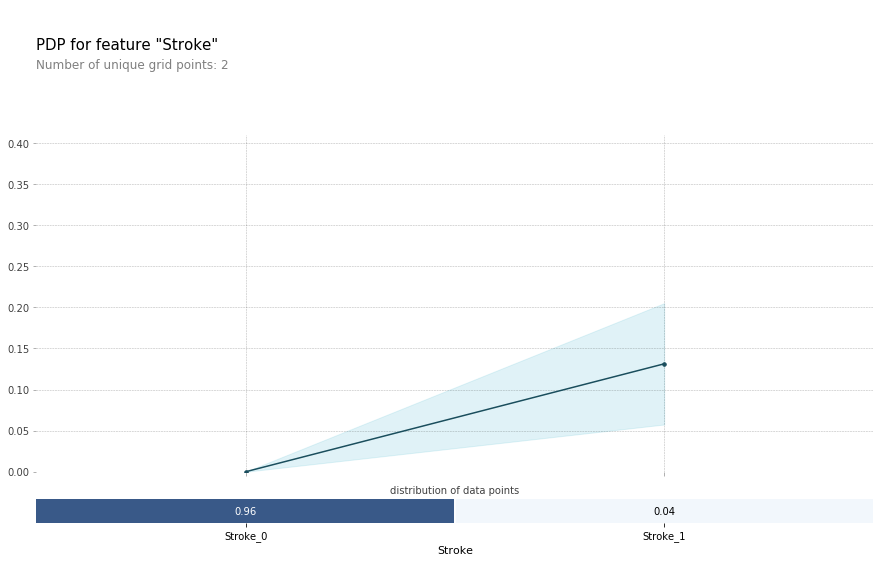

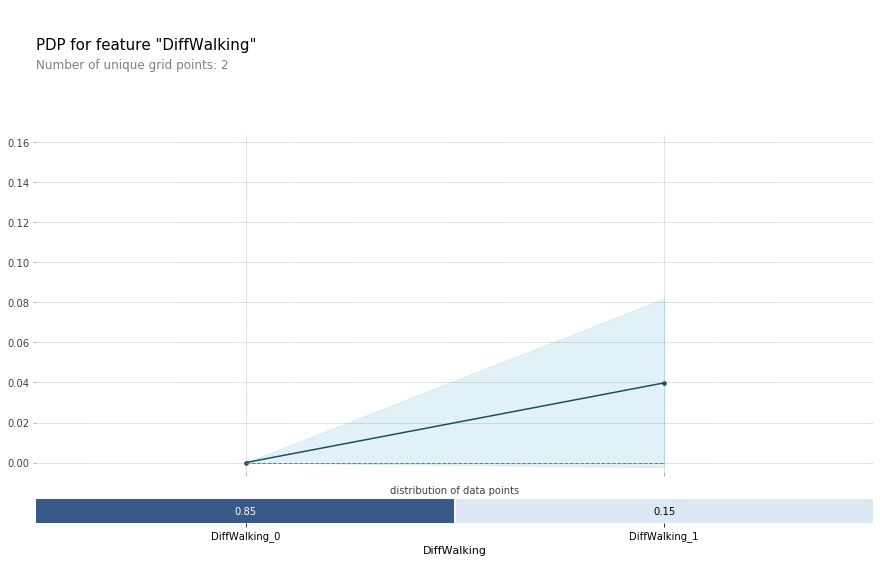

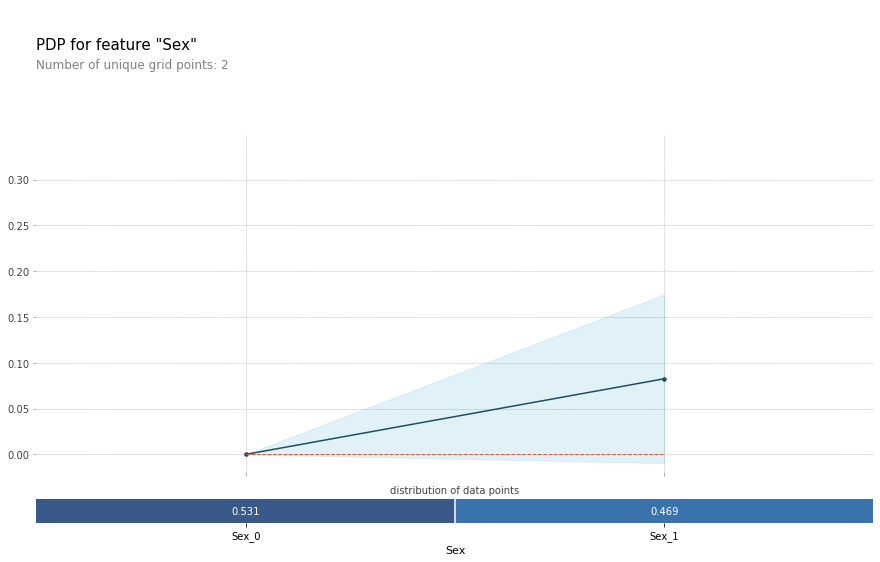

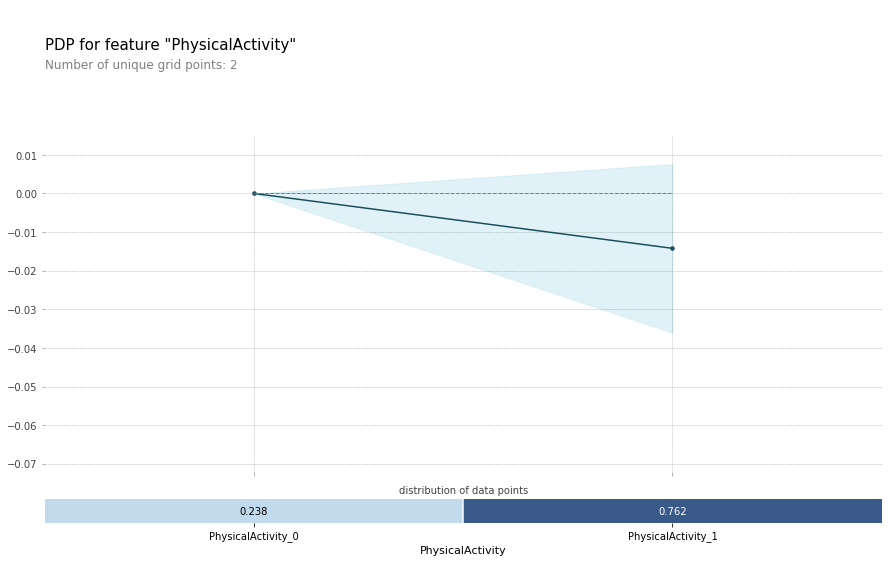

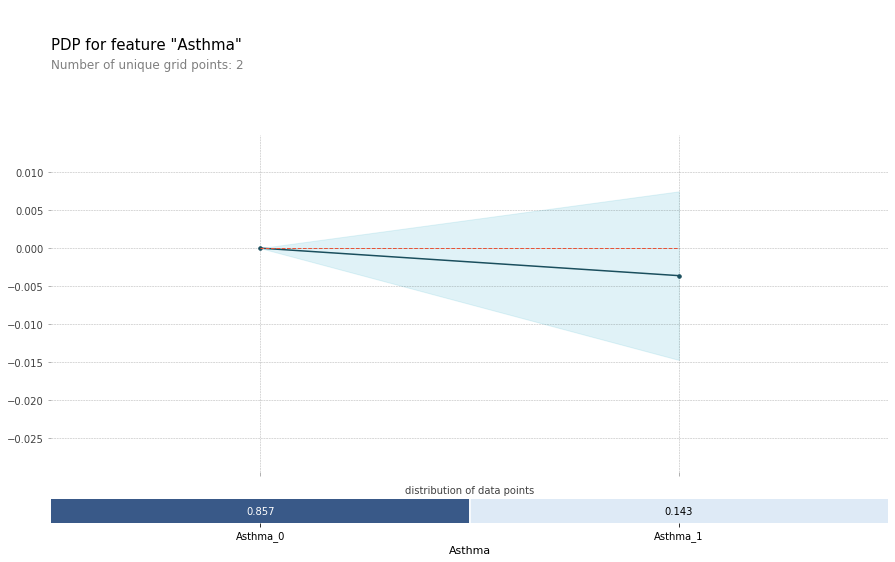

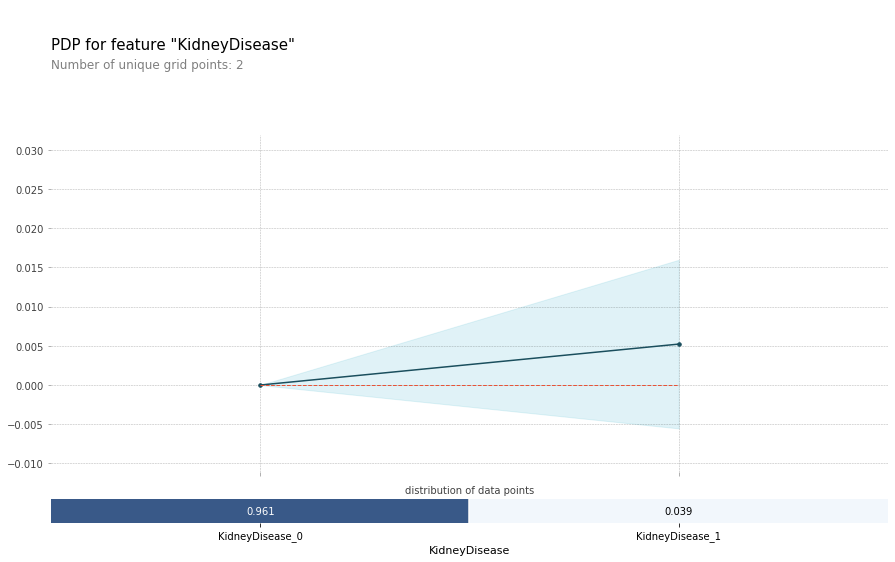

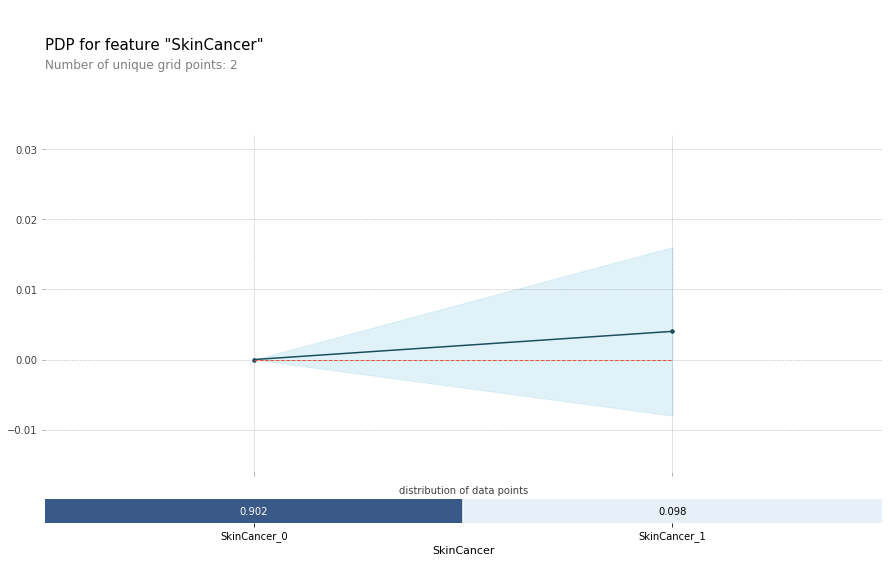

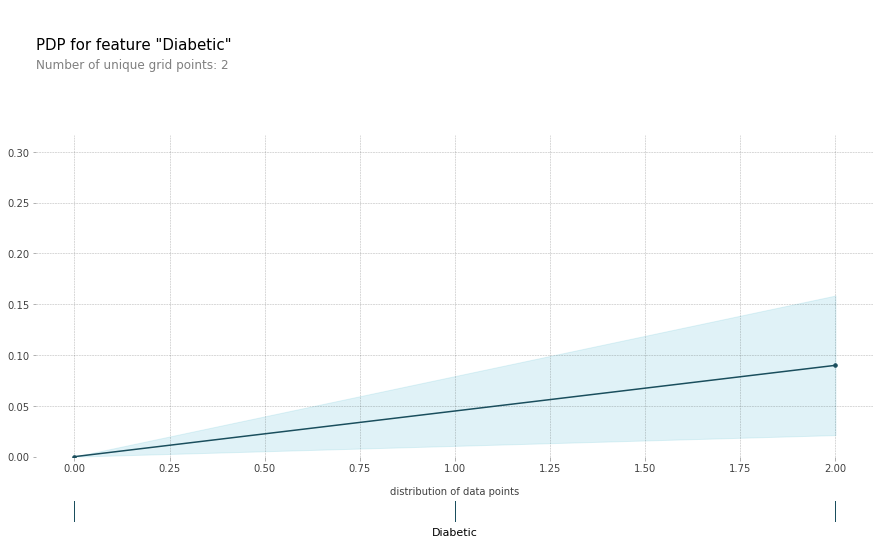

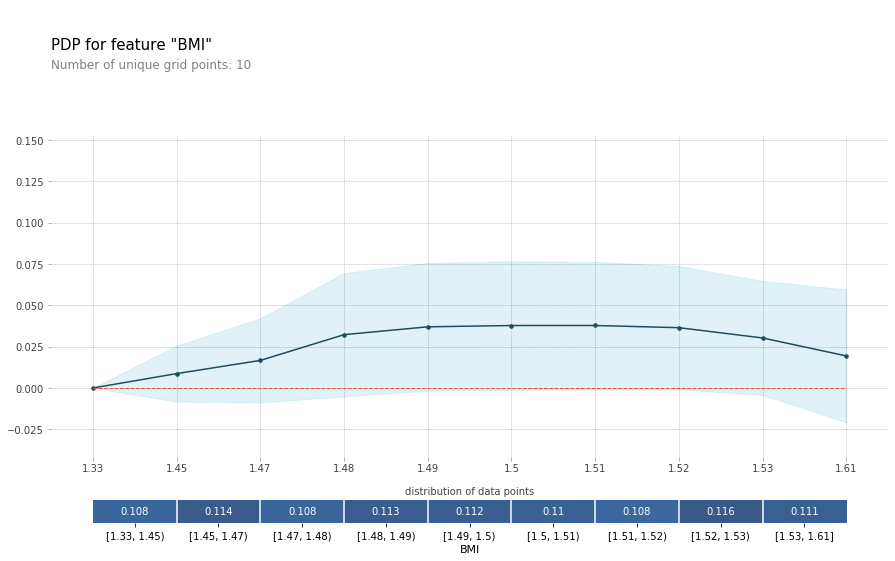

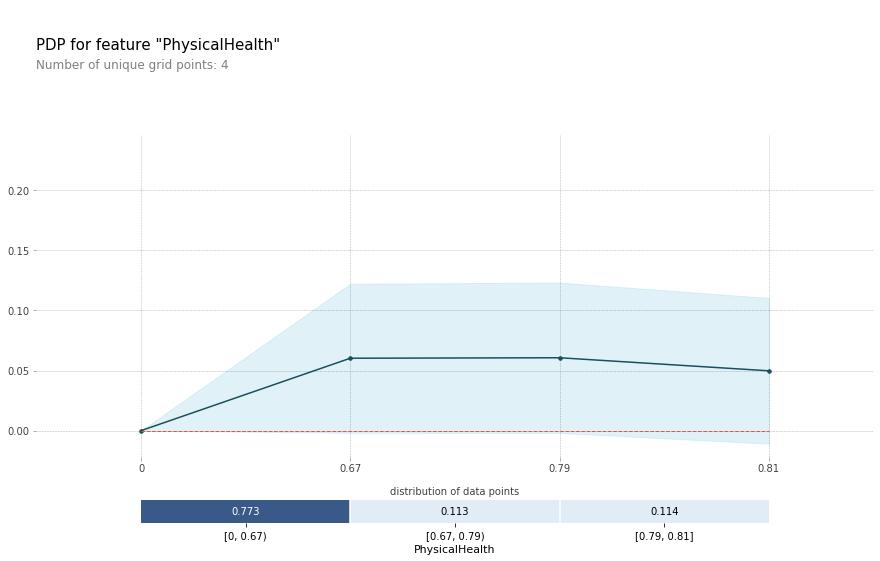

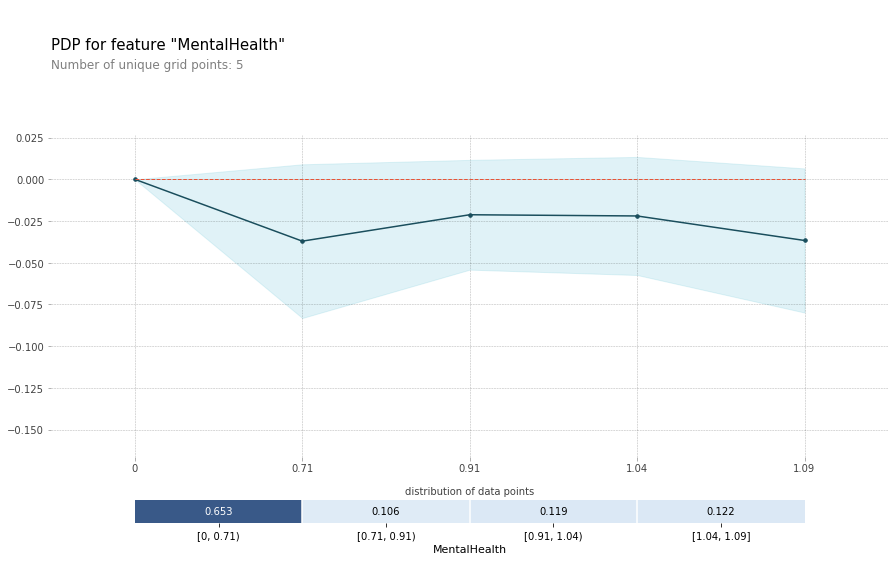

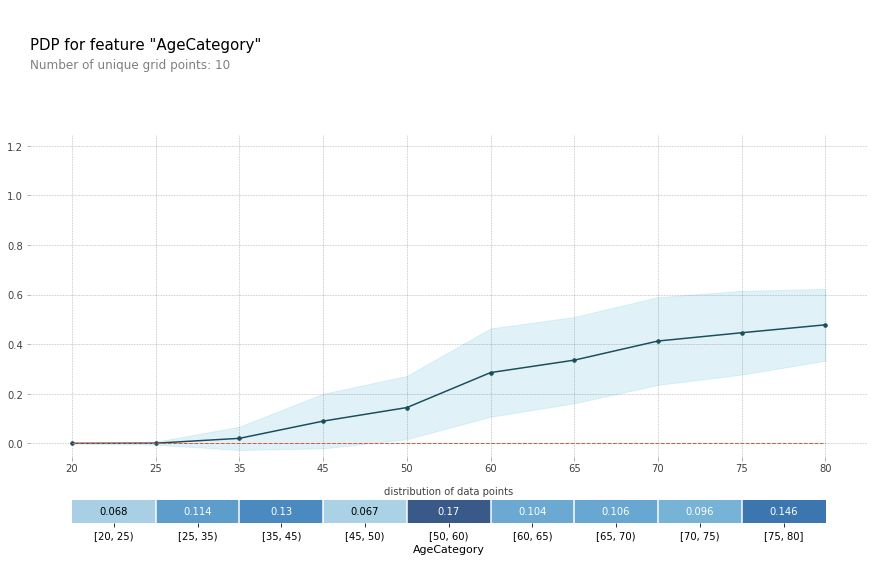

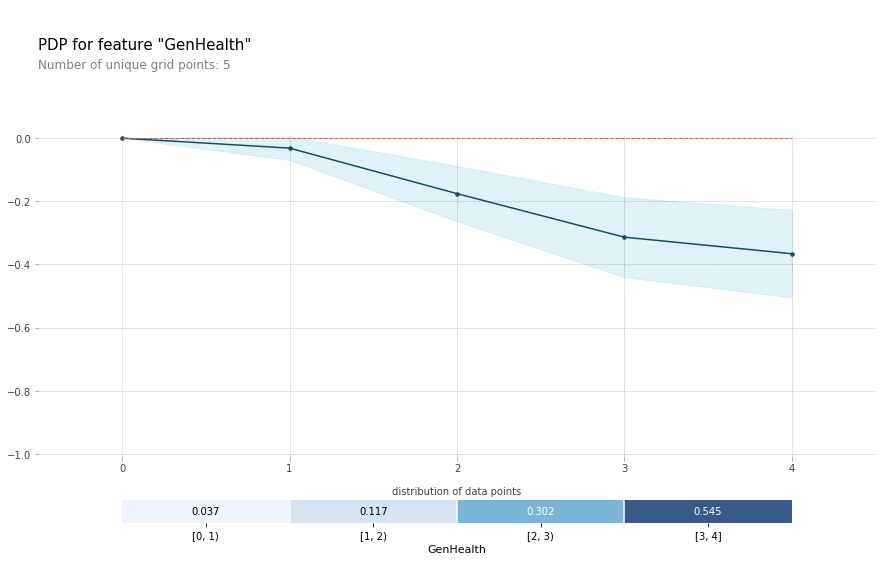

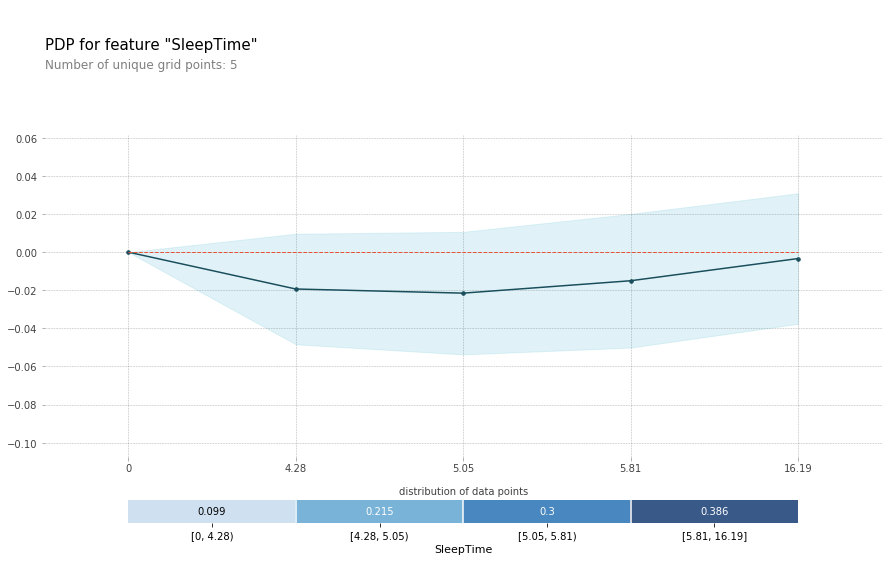

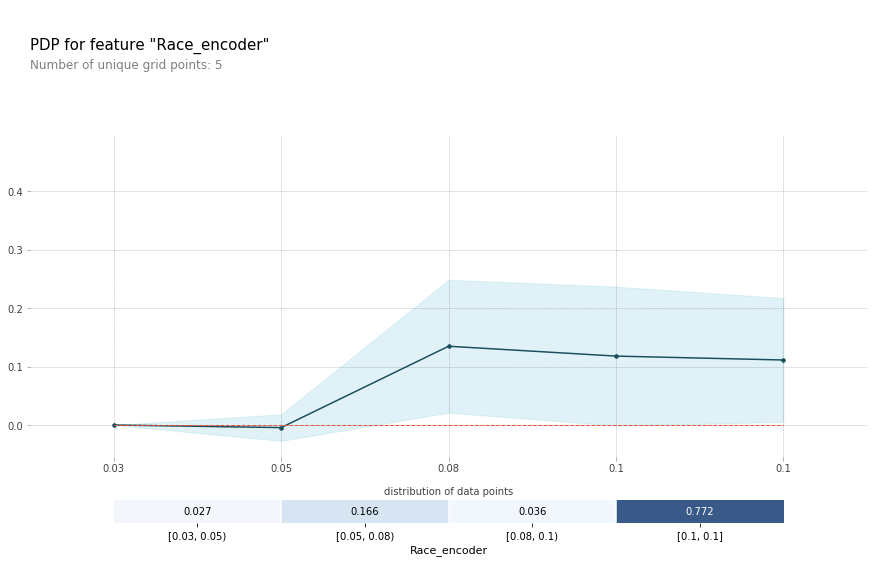

In [ ]:
# 샘플링 없는 pdp
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i], plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], plot_pts_dist=True,  x_quantile=True)

In [ ]:
# 샘플링 적용안한 경우의 center ICE
for i in range (len(feature)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature[i])
  pdp.pdp_plot(pdp_res, feature[i],frac_to_plot=800, plot_lines=True, plot_pts_dist=True)
for i in range (len(feature2)):
  pdp_res = pdp.pdp_isolate(model=model, dataset=x_test, model_features=features, feature=feature2[i])
  pdp.pdp_plot(pdp_res, feature2[i], frac_to_plot=800, plot_lines=True, plot_pts_dist=True,  x_quantile=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

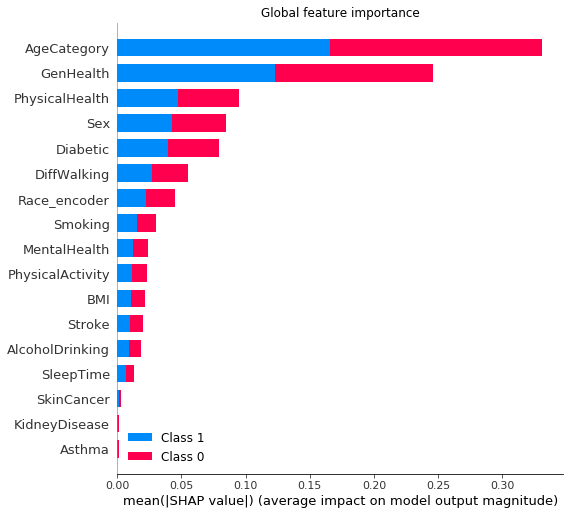

In [ ]:
plt.title('Global feature importance')
shap.summary_plot(shap_values,feature_names=features)

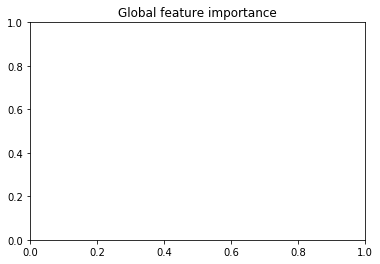

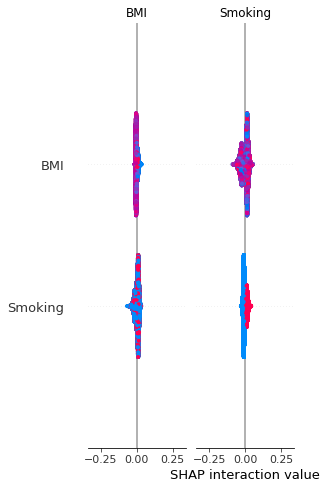

In [ ]:
plt.title('Global feature importance')
shap.summary_plot(shap_values,feature_names=features)

In [ ]:
#오버 샘플링 결과

print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SMOTE :\n', y_train_SMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter BoderlineSMOTE :\n', y_train_BorderlineSM.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter SVMSMOTE :\n', y_train_SVMSMOTE.value_counts())
print('\n\n')
print('befor oversampling :\n', y_train.value_counts())
print('\nAfter ADASYN :\n', y_train_ADASYN.value_counts())
print('\n\n')

befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After BoderlineSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After SVMSMOTE :
 1    219556
0    219556
Name: HeartDisease, dtype: int64



befor oversampling :
 0    219556
1     21766
Name: HeartDisease, dtype: int64

After ADASYN :
 1    220204
0    219556
Name: HeartDisease, dtype: int64





OverSampling SMOTE
Accuracy 0.8391705756576221
Precision 0.2399161218699889
Recall 0.3545388261028071
F1 0.28617670860001465
AUC 0.7742233448341658
[[48683  6162]
 [ 3541  1945]]


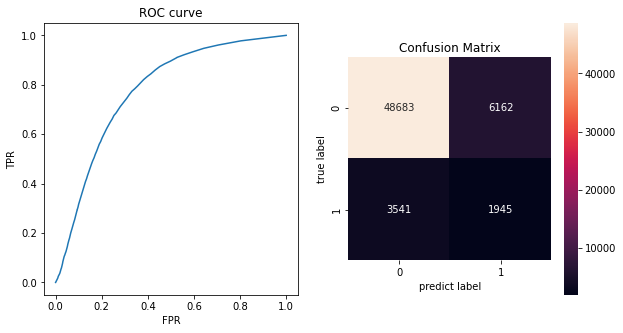

In [ ]:
#로지스틱 이용 샘플링 안한경우
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier()
model.fit(x_train_SMOTE, y_train_SMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

print('OverSampling SMOTE')
print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

OverSampling BorderlineSM
Accuracy 0.8477731182973928
Precision 0.2539914848323576
Recall 0.34797666788188114
F1 0.29364713121058295
AUC 0.788091443665835
[[49238  5607]
 [ 3577  1909]]


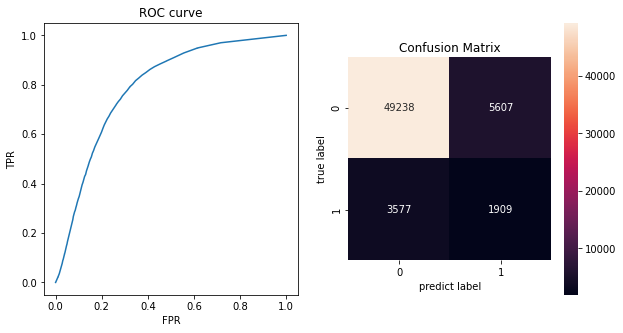

In [ ]:
#로지스틱 이용 샘플링 안한경우
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier()
model.fit(x_train_BorderlineSM, y_train_BorderlineSM)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

print('OverSampling BorderlineSM')
print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

OverSampling SVMSMOTE
Accuracy 0.8579668826971208
Precision 0.2736084593919812
Recall 0.33959168793292016
F1 0.30305002033346884
AUC 0.7916731911464806
[[49899  4946]
 [ 3623  1863]]


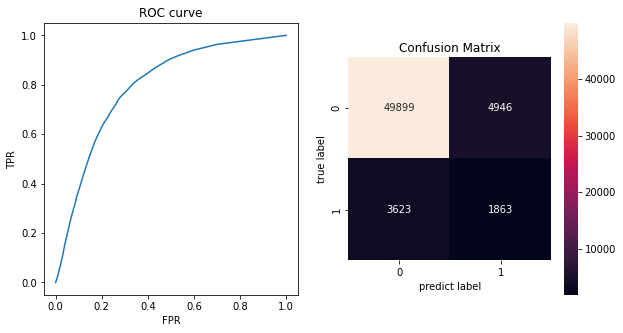

In [ ]:
#로지스틱 이용 샘플링 안한경우
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier()
model.fit(x_train_SVMSMOTE, y_train_SVMSMOTE)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

print('OverSampling SVMSMOTE')

print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()

OverSampling ADASYN
Accuracy 0.8346952644577414
Precision 0.2314781567923399
Recall 0.35253372220196866
F1 0.27945957662018645
AUC 0.7720147310052554
[[48424  6421]
 [ 3552  1934]]


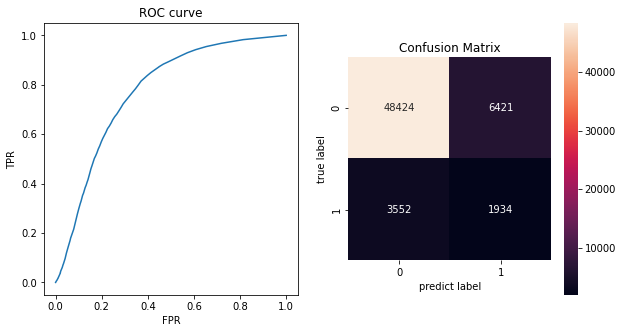

In [ ]:
#로지스틱 이용 샘플링 안한경우
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier()
model.fit(x_train_ADASYN, y_train_ADASYN)
y_pred = model.predict(x_test)

acc = metrics.accuracy_score(y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Display confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

print('OverSampling ADASYN')

print(f"Accuracy {acc}")
print(f"Precision {prec}")
print(f"Recall {rec}")
print(f"F1 {f1}")
print(f"AUC {auc}")

print(cm)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')


plt.subplot(1,2,2)
plt.title('Confusion Matrix')
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar='False')
plt.xlabel('predict label')
plt.ylabel('true label')
plt.show()